In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, model_selection, tree
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi']=300



scaler = MinMaxScaler()

     
# Classifiers
classifiers = {"Naive \nBayes": GaussianNB(), 
               "Adaptive \nBoosting": AdaBoostClassifier(), 
               "Decision \nTree": DecisionTreeClassifier(), 
               "Random \nForest": RandomForestClassifier(random_state=42),
               "Logistic \nRegression": LogisticRegression()
              }


def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]

        clf_class.fit(X_train,y_train)

        y_prob[test_index] = clf_class.predict_proba(X_test)
    return y_prob

data = pd.read_csv('../../Data/chenhao_pairs.csv')

measures_category = {'non-network': list(data.columns[5:-11]),
                     'network': ['deg_ratio'],
                     'all': list(data.columns[5:-11]) + ['deg_ratio'] }


Bad key text.latex.preview in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

In [2]:
results = {}
y = data['outcome'].values
for name in tqdm_notebook(classifiers.keys()):
    print(name)
    results[name] = {}
    for category, features in tqdm_notebook(measures_category.items()):
        print(category)
        auc_scores = []
        if category=='network':
            X = data['deg_ratio'].to_numpy().reshape(-1,1)
            X = scaler.fit_transform(X)
        else:
            X = data[features].to_numpy()
            X = scaler.fit_transform(X)
        
        for i in tqdm_notebook(range(100)):
            clf = classifiers.get(name)
            probs = run_prob_cv(X,y,clf)

            fpr, tpr, threshold = metrics.roc_curve(y, probs[:,1])

            auc_scores.append(metrics.auc(fpr, tpr))

        results[name][category] = auc_scores

Naive 
Bayes


non-network



network



all




Adaptive 
Boosting


non-network



network



all




Decision 
Tree


non-network



network



all




Random 
Forest


non-network



network



all




Logistic 
Regression


non-network



network



all


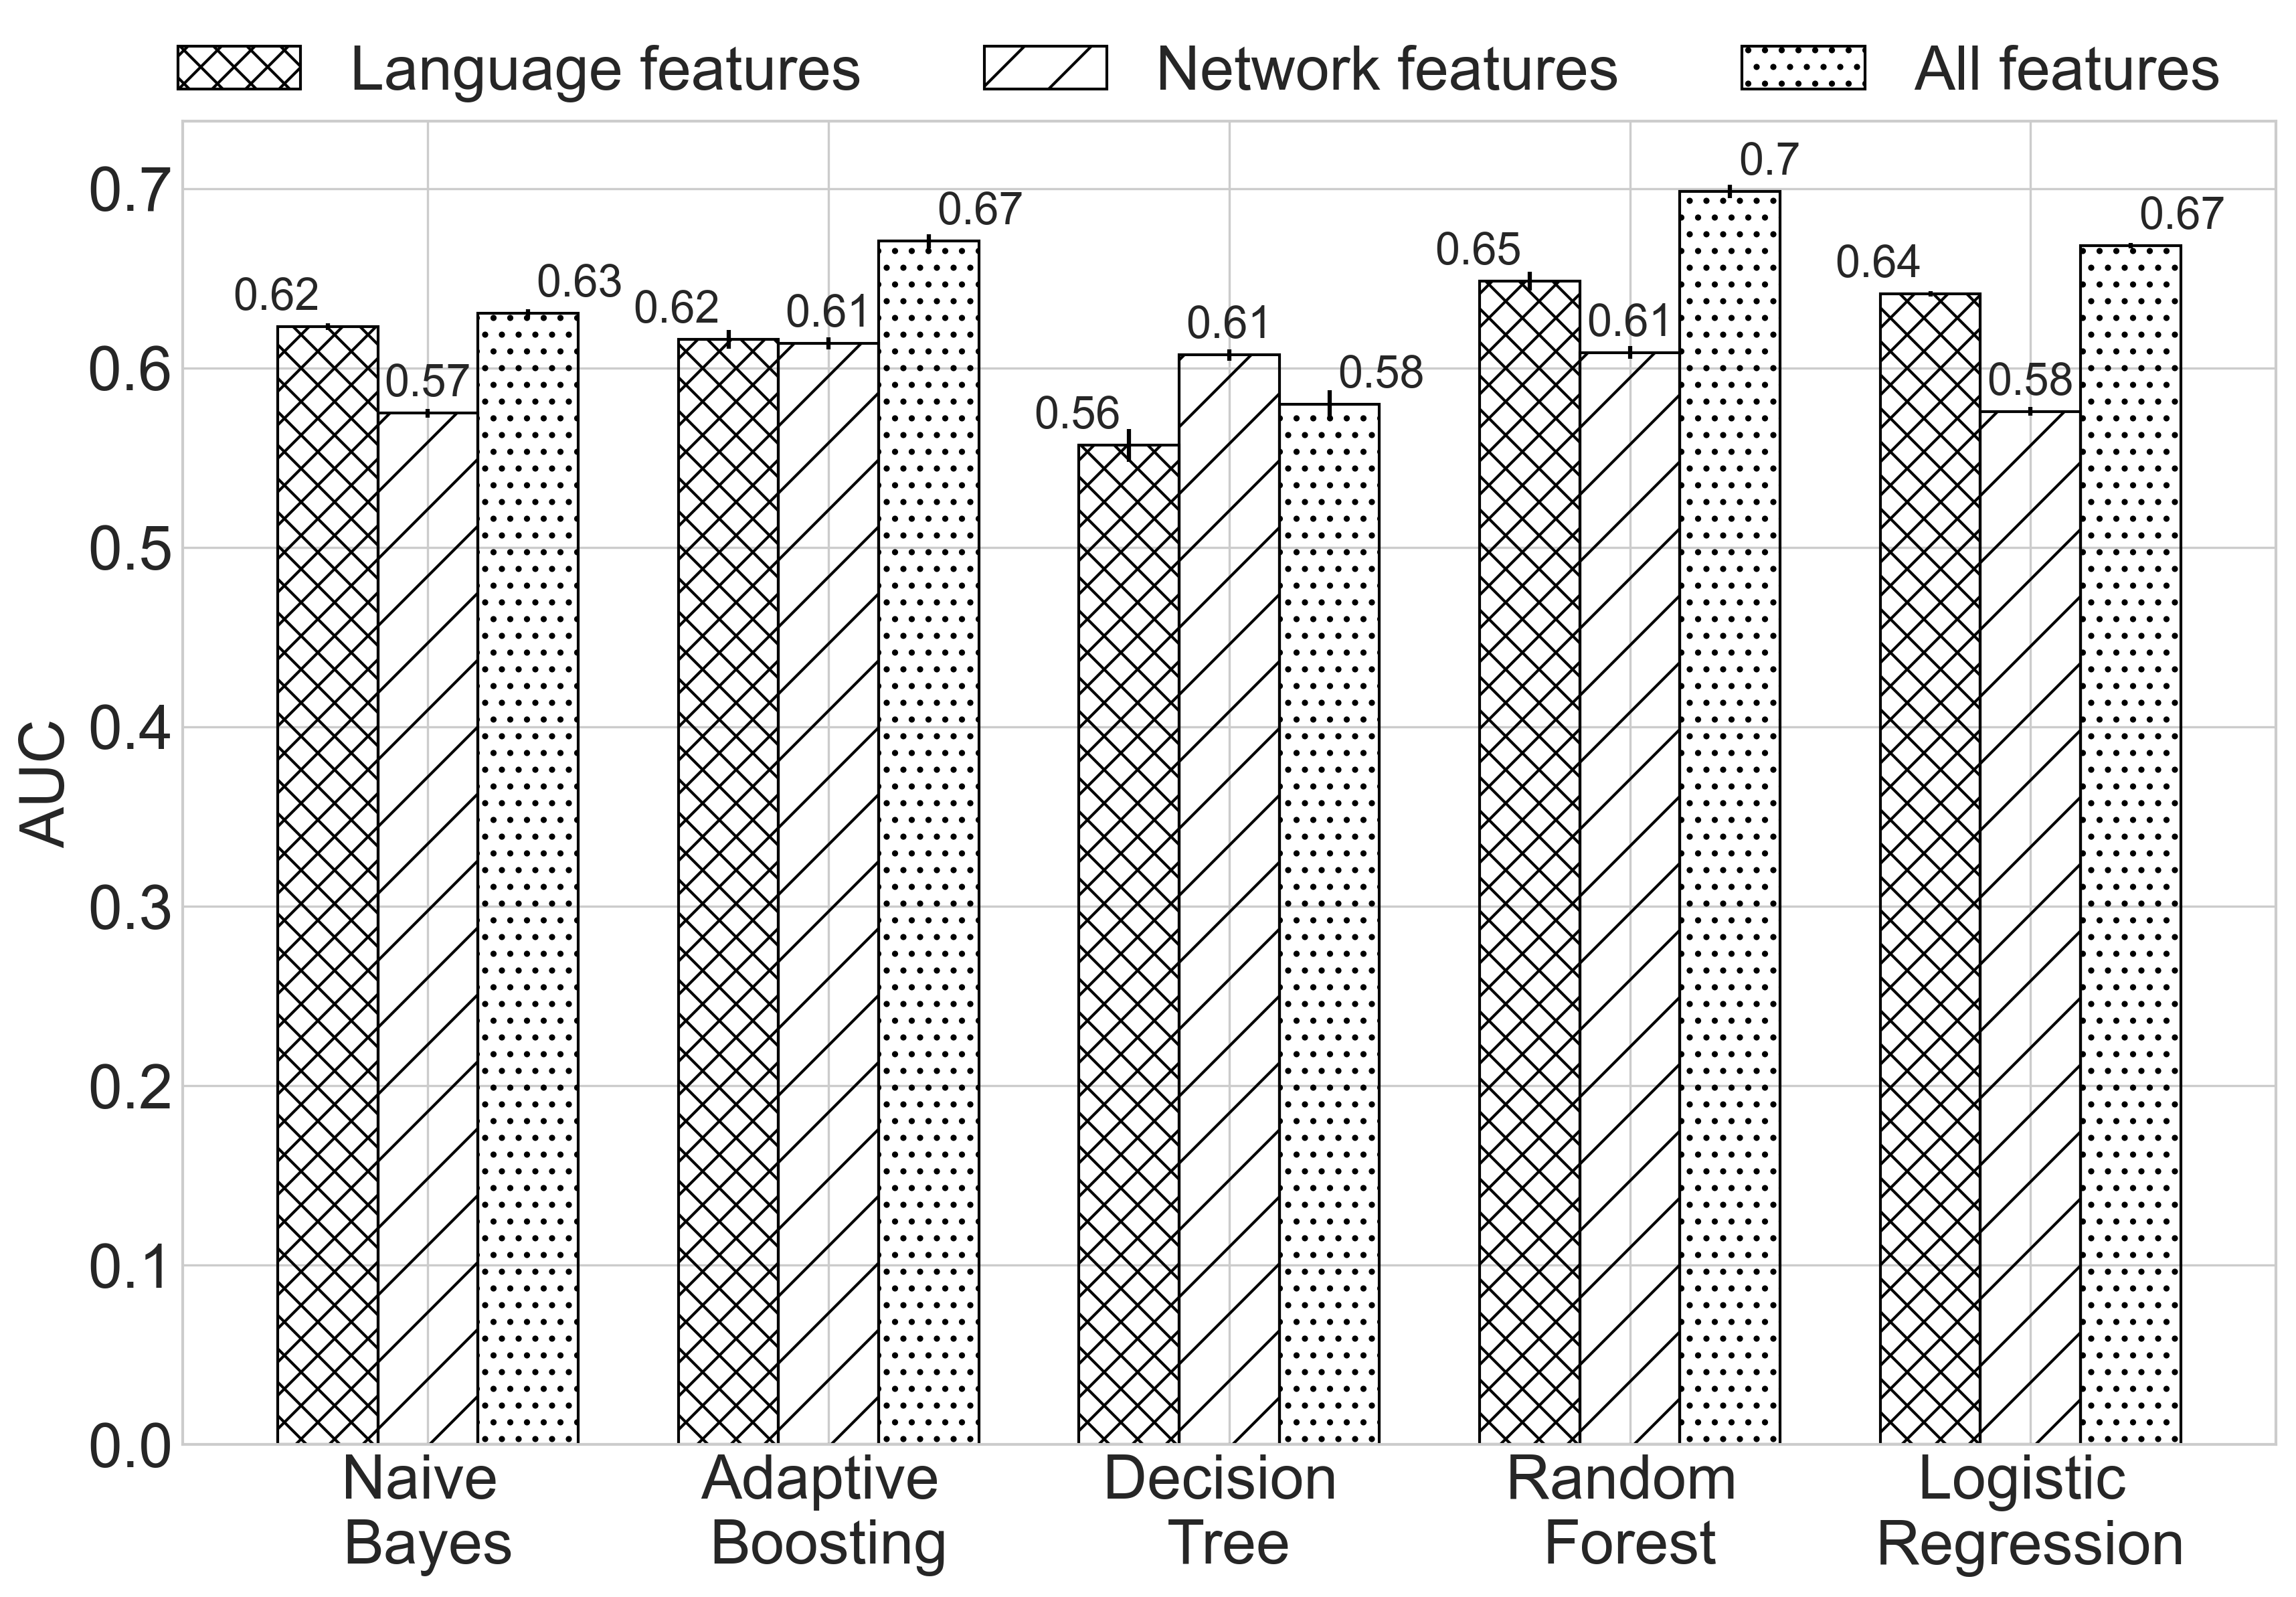

In [13]:
non_network_means, non_network_std = [np.mean(v['non-network']) for k, v in results.items()], [np.std(v['non-network']) for k, v in results.items()]
network_means, network_std = [np.mean(v['network']) for k, v in results.items()], [np.std(v['network']) for k, v in results.items()]
all_means, all_std = [np.mean(v['all']) for k, v in results.items()], [np.std(v['all']) for k, v in results.items()]


s= 22

ind = np.arange(len(non_network_means))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8), dpi=300, layout='constrained')

rects1 = ax.bar(ind - width, non_network_means, width, yerr=non_network_std,
                label='Language features', color='#FFA500', fill=False, hatch='xx')

rects2 = ax.bar(ind, network_means, width, yerr=network_std,
                label='Network features', color='grey', fill=False, hatch='/')

rects3 = ax.bar(ind + width, all_means, width, yerr=all_std,
                label='All features', color='#0A8484', fill=False, hatch='..')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC', fontsize=s)
# ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(list(results.keys()))
ax.legend(bbox_to_anchor=(1, 1.1),ncol=3, fontsize=s)


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),fontsize=s-6,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

plt.xticks(fontsize=s)
plt.yticks(fontsize=s)

plt.tight_layout()
plt.show()

In [17]:
pd.DataFrame.from_dict(results).to_pickle('evaluation_bootstrap.pkl')